In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
ratings = pd.read_csv('ratings.csv').drop(['Unnamed: 0'], axis=1)
providers = pd.read_csv('providers.csv').drop(['Unnamed: 0'], axis=1)

In [6]:
def ttsplit(examples, labels, test_size=0.1, verbose=0):
    from sklearn.model_selection import train_test_split 
    
    if verbose:
        print("Train/Test split ")
        print(100-test_size*100, "% of training data")
        print(test_size*100, "% of testing data")    

    # split data into train and test sets
    train_examples, test_examples, train_labels, test_labels = train_test_split(
        examples, 
        labels, 
        test_size=0.1, 
        random_state=42, 
        shuffle=True
    )

    # transform train and test examples to their corresponding one-hot representations
    train_users = train_examples[:, 0]
    test_users = test_examples[:, 0]

    train_items = train_examples[:, 1]
    test_items = test_examples[:, 1]

    # Final training and test set
    x_train = np.array(list(zip(train_users, train_items)))
    x_test = np.array(list(zip(test_users, test_items)))

    y_train = train_labels
    y_test = test_labels

    if verbose:
        print()
        print('number of training examples : ', x_train.shape)
        print('number of training labels : ', y_train.shape)
        print('number of test examples : ', x_test.shape)
        print('number of test labels : ', y_test.shape)

    return (x_train, x_test), (y_train, y_test)

def mean_ratings(dataframe):
    means = dataframe.groupby(by='User_id', as_index=False)['rating'].mean()
    return means


def normalized_ratings(dataframe, norm_column="norm_rating"):
    """
    Нормализация рейтинга пользователя относительно общего среднего
    """
    mean = mean_ratings(dataframe=dataframe)
    norm = pd.merge(dataframe, mean, suffixes=('', '_mean'), on='User_id')
    norm[f'{norm_column}'] = norm['rating'] - norm['rating_mean']

    return norm


def rating_matrix(dataframe, column):
    crosstab = pd.crosstab(dataframe['User_id'], dataframe['Registration number'], dataframe[f'{column}'], aggfunc=sum).fillna(0).values()
    matrix = csr_matrix(crosstab)
    return matrix


def scale_ratings(dataframe, scaled_column="scaled_rating"):
    dataframe[f"{scaled_column}"] = dataframe.rating / 5.0
    return dataframe


def get_examples(dataframe, labels_column="rating"):
    examples = dataframe[['User_id', 'Registration number']].values
    labels = dataframe[f'{labels_column}'].values
    return examples, labels

In [7]:
def ids_encoder(ratings):
    """
        Энкодер для более удобной работы
    """
    users = sorted(ratings['User_id'].unique())
    items = sorted(ratings['Registration number'].unique())

    # энкодер для пользователей и элементов
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit
    uencoder.fit(users)
    iencoder.fit(items)

    # перезапись ID
    ratings['User_id'] = uencoder.transform(ratings['User_id'].tolist())
    ratings['Registration number'] = iencoder.transform(ratings['Registration number'].tolist())

    return ratings, uencoder, iencoder

## Non-negative Matrix Factorization

In [71]:
class NMF:
    
    def __init__(self, ratings, m, n, uencoder, iencoder, K=10, lambda_P=0.01, lambda_Q=0.01):
        
        np.random.seed(32)
        
        # инициализация матриц P / Q по переданной размерности
        self.ratings = ratings
        self.np_ratings = ratings.to_numpy()
        self.K = K
        self.P = np.random.rand(m, K)
        self.Q = np.random.rand(n, K)
        
        # гиперпараметры
        self.lambda_P = lambda_P
        self.lambda_Q = lambda_Q

        # энкодеры
        self.uencoder = uencoder
        self.iencoder = iencoder
        
        # словарь для сохранения обучения 
        self.history = {
            "epochs": [],
            "loss": [],
            "val_loss": [],
        }

    def print_training_parameters(self):
        print('Training NMF ...')
        print(f'k={self.K}')
        
    def mae(self, x_train, y_train):
        """
        функция возвращает MAE
        """
        # кол-во в сэплте
        m = x_train.shape[0]
        error = 0
        for pair, r in zip(x_train, y_train):
            u, i = pair
            error += abs(r - np.dot(self.P[u], self.Q[i]))
        return error / m
    
    def update_rule(self, u, i, error):
        # основные изменения, отличие от MF
        I = self.np_ratings[self.np_ratings[:, 0] == u][:, [1, 2]]
        U = self.np_ratings[self.np_ratings[:, 1] == i][:, [0, 2]]    
        
        l = []
        for el in range(len(I[:, 0])):
            l.append(int(I[:, 0][el]))
        
        num = self.P[u] * np.dot(self.Q[l].T, I[:, 1])
        dem = np.dot(self.Q[l].T, np.dot(self.P[u], self.Q[l].T)) + self.lambda_P * len(I) * self.P[u]
        self.P[u] = num / dem
        
        m = []
        for el in range(len(U[:, 0])):
            m.append(int(U[:, 0][el]))

        num = self.Q[i] * np.dot(self.P[m].T, U[:, 1])
        dem = np.dot(self.P[m].T, np.dot(self.P[m], self.Q[i].T)) + self.lambda_Q * len(U) * self.Q[i]
        self.Q[i] = num / dem
    
    @staticmethod
    def print_training_progress(epoch, epochs, error, val_error, steps=5):
        if epoch == 1 or epoch % steps == 0:
            print(f"epoch {epoch}/{epochs} - loss : {round(error, 3)} - val_loss : {round(val_error, 3)}")
                   
    def fit(self, x_train, y_train, validation_data, epochs=10):

        self.print_training_parameters()
        x_test, y_test = validation_data
        for epoch in range(1, epochs+1):
            for pair, r in zip(x_train, y_train):
                u, i = pair
                r_hat = np.dot(self.P[u], self.Q[i])
                e = abs(r - r_hat)
                self.update_rule(u, i, e)                
            # обучение и тестирование 
            error = self.mae(x_train, y_train)
            val_error = self.mae(x_test, y_test)
            self.update_history(epoch, error, val_error)
            self.print_training_progress(epoch, epochs, error, val_error, steps=1)
        
        return self.history
    
    def update_history(self, epoch, error, val_error):
        self.history['epochs'].append(epoch)
        self.history['loss'].append(error)
        self.history['val_loss'].append(val_error)
    
    def evaluate(self, x_test, y_test):        
        error = self.mae(x_test, y_test)
        print(f"validation error : {round(error,3)}")
        print('MAE : ', error)        
        return error
      
    def predict(self, userid, itemid):
        u = self.uencoder.transform([userid])[0]
        i = self.iencoder.transform([itemid])[0]
        r = np.dot(self.P[u], self.Q[i])
        return r
    
    def recommend(self, userid, N=10):
        
        u = uencoder.transform([userid])[0]
        
        # предикт
        predictions = np.dot(self.P[u], self.Q.T)

        # индекст Топ N
        # только необходимое кол-во
        top_items = self.iencoder.inverse_transform(top_idx)
        top_idx = np.flip(np.argsort(predictions))[:N]
        preds = predictions[top_idx]

        return top_items, preds

## Training NMF
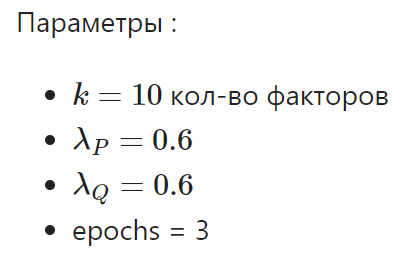

### Initial ratings (not normalized)

In [73]:
## initial rating
m = ratings['User_id'].nunique()   # всего пользователей
n = ratings['Registration number'].nunique()   # всего элементов

ratings, uencoder, iencoder = ids_encoder(ratings)

# получение данных в подготовленном виде
raw_examples, raw_labels = get_examples(ratings)

# train test split
(x_train, x_test), (y_train, y_test) = ttsplit(examples=raw_examples, labels=raw_labels)

In [74]:
m = ratings['User_id'].nunique()  
n = ratings['Registration number'].nunique() 

# обучаем
nmf = NMF(ratings, m, n, uencoder, iencoder, K=10, lambda_P=0.6, lambda_Q=0.6)
history = nmf.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Training NMF ...
k=10
epoch 1/5 - loss : 1.23 - val_loss : 1.238
epoch 2/5 - loss : 1.226 - val_loss : 1.232
epoch 3/5 - loss : 1.225 - val_loss : 1.23
epoch 4/5 - loss : 1.224 - val_loss : 1.229
epoch 5/5 - loss : 1.224 - val_loss : 1.228


In [75]:
nmf.evaluate(x_test, y_test)

validation error : 1.228
MAE :  1.2284058454599553


1.2284058454599553

## Prediction

In [79]:
ratings.userid = uencoder.inverse_transform(ratings['User_id'].to_list())
ratings.itemid = iencoder.inverse_transform(ratings['Registration number'].to_list())
ratings.head(5)

,User_id,Registration number,rating,rating_mean,norm_rating
0,0,0,0.8,2.486881,-1.686881
1,0,661,3.5,2.486881,1.013119
2,0,1989,2.4,2.486881,-0.086881
3,0,7899,3.7,2.486881,1.213119
4,0,3097,1.2,2.486881,-1.286881


In [80]:
k = ratings[ratings['User_id'] == 0].sort_values(by='rating')
# k[k['Registration number'] == 5678]
k

,User_id,Registration number,rating,rating_mean,norm_rating
1692,0,2934,0.0,2.486881,-2.486881
3274,0,6597,0.0,2.486881,-2.486881
1504,0,2115,0.0,2.486881,-2.486881
2641,0,6111,0.0,2.486881,-2.486881
3339,0,1060,0.0,2.486881,-2.486881
...,...,...,...,...,...
2582,0,3650,5.0,2.486881,2.513119
2102,0,6065,5.0,2.486881,2.513119
4604,0,110,5.0,2.486881,2.513119
2121,0,1221,5.0,2.486881,2.513119


In [ ]:
reg_num = set(ratings['Registration number'].tolist())
user = set(ratings[ratings['User_id'] == 0]['Registration number'].tolist())
diff = list(reg_num - user)